# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import List, Tuple
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

from torchvision import datasets

from skimage.feature import hog, local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## **Configurazione + Device**

In [3]:
@dataclass
class Config:
    # paths
    data_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset"
    #data_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset"
    fit_dir  = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid"
    #fit_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/valid"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test_degradato"
    
    img_size = 128   # per HOG spesso 128 va benissimo
    use_preprocess = True  # GrayWorld + AutoContrast

    # tuning
    test_size_internal = 0.2
    random_state = 42
    C_grid = (0.1, 0.3, 1.0, 3.0, 10.0)
    max_iter = 50000

def sanity_check_paths(cfg: Config):
    for p in [cfg.data_dir, cfg.fit_dir, cfg.test_dir]:
        if not os.path.exists(p):
            raise FileNotFoundError(f"Path not found: {p}")
    print("OK paths")
    print("fit_dir:", cfg.fit_dir)
    print("test_dir:", cfg.test_dir)

## **Preprocessing**

In [4]:
class GrayWorldWB:
    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.asarray(img).astype(np.float32)
        mean = arr.mean(axis=(0, 1), keepdims=True)
        arr = arr / (mean + 1e-6)
        arr = arr / (arr.max() + 1e-6)
        return Image.fromarray((arr * 255).astype(np.uint8))

class AutoContrast:
    def __call__(self, img: Image.Image) -> Image.Image:
        return ImageOps.autocontrast(img, cutoff=1)

def preprocess_pil(img: Image.Image, cfg: Config) -> Image.Image:
    if cfg.use_preprocess:
        img = GrayWorldWB()(img)
        img = AutoContrast()(img)
    return img

## **Feature Extraction**

In [5]:
def feat_hog(path: str, cfg: Config) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    img = preprocess_pil(img, cfg)
    img = img.resize((cfg.img_size, cfg.img_size))
    img_gray = np.array(img.convert("L"))

    return hog(
        img_gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys",
        feature_vector=True
    ).astype(np.float32)

def feat_lbp(path: str, cfg: Config, P: int = 8, R: int = 1) -> np.ndarray:
    img = Image.open(path).convert("RGB")
    img = preprocess_pil(img, cfg)
    img = img.resize((cfg.img_size, cfg.img_size))
    img_gray = np.array(img.convert("L"))

    lbp = local_binary_pattern(img_gray, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-8)
    return hist

def feat_hog_lbp(path: str, cfg: Config) -> np.ndarray:
    return np.concatenate([feat_hog(path, cfg), feat_lbp(path, cfg)], axis=0)

## **Dataset**

In [6]:
def build_xy(folder: datasets.ImageFolder, cfg: Config, mode: str) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for path, label in folder.samples:
        if mode == "hog":
            X.append(feat_hog(path, cfg))
        elif mode == "lbp":
            X.append(feat_lbp(path, cfg))
        elif mode == "hog+lbp":
            X.append(feat_hog_lbp(path, cfg))
        else:
            raise ValueError("mode must be: 'hog', 'lbp', 'hog+lbp'")
        y.append(label)
    return np.asarray(X), np.asarray(y)

## **Evaluation su test + Matrice di confusione**

In [7]:
def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix (normalized)"):
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


def print_top_confusions(cm: np.ndarray, class_names: List[str], top_k: int = 100):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")

def tune_and_test(X_fit, y_fit, X_test, y_test, cfg: Config):
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_fit, y_fit,
        test_size=cfg.test_size_internal,
        random_state=cfg.random_state,
        stratify=y_fit
    )

    best_C, best_f1 = None, -1.0
    for C in cfg.C_grid:
        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", LinearSVC(C=C, max_iter=cfg.max_iter))
        ])
        clf.fit(X_tr, y_tr)
        y_val_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_val_pred, average="macro", zero_division=0)
        if f1 > best_f1:
            best_f1, best_C = f1, C

    # fit finale su tutto il VALID
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(C=best_C, max_iter=cfg.max_iter))
    ])
    clf.fit(X_fit, y_fit)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro", zero_division=0)
    cm  = confusion_matrix(y_test, y_pred)
    return best_C, best_f1, acc, f1, cm

## **Main**

In [8]:
cfg = Config()
sanity_check_paths(cfg)

OK paths
fit_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid
test_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato


In [9]:
fit_ds  = datasets.ImageFolder(cfg.fit_dir)   # VALID come training del task3
test_ds = datasets.ImageFolder(cfg.test_dir)

print("Fit classes:", fit_ds.classes)
print("Test classes:", test_ds.classes)
assert fit_ds.classes == test_ds.classes, "ATTENZIONE: class order diverso tra fit e test!"

class_names = fit_ds.classes

Fit classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbi


MODE = hog
Best C (val split): 0.1 | Val Macro-F1: 0.0923
TEST(degradato) Accuracy: 0.0980
TEST(degradato) Macro-F1: 0.0905


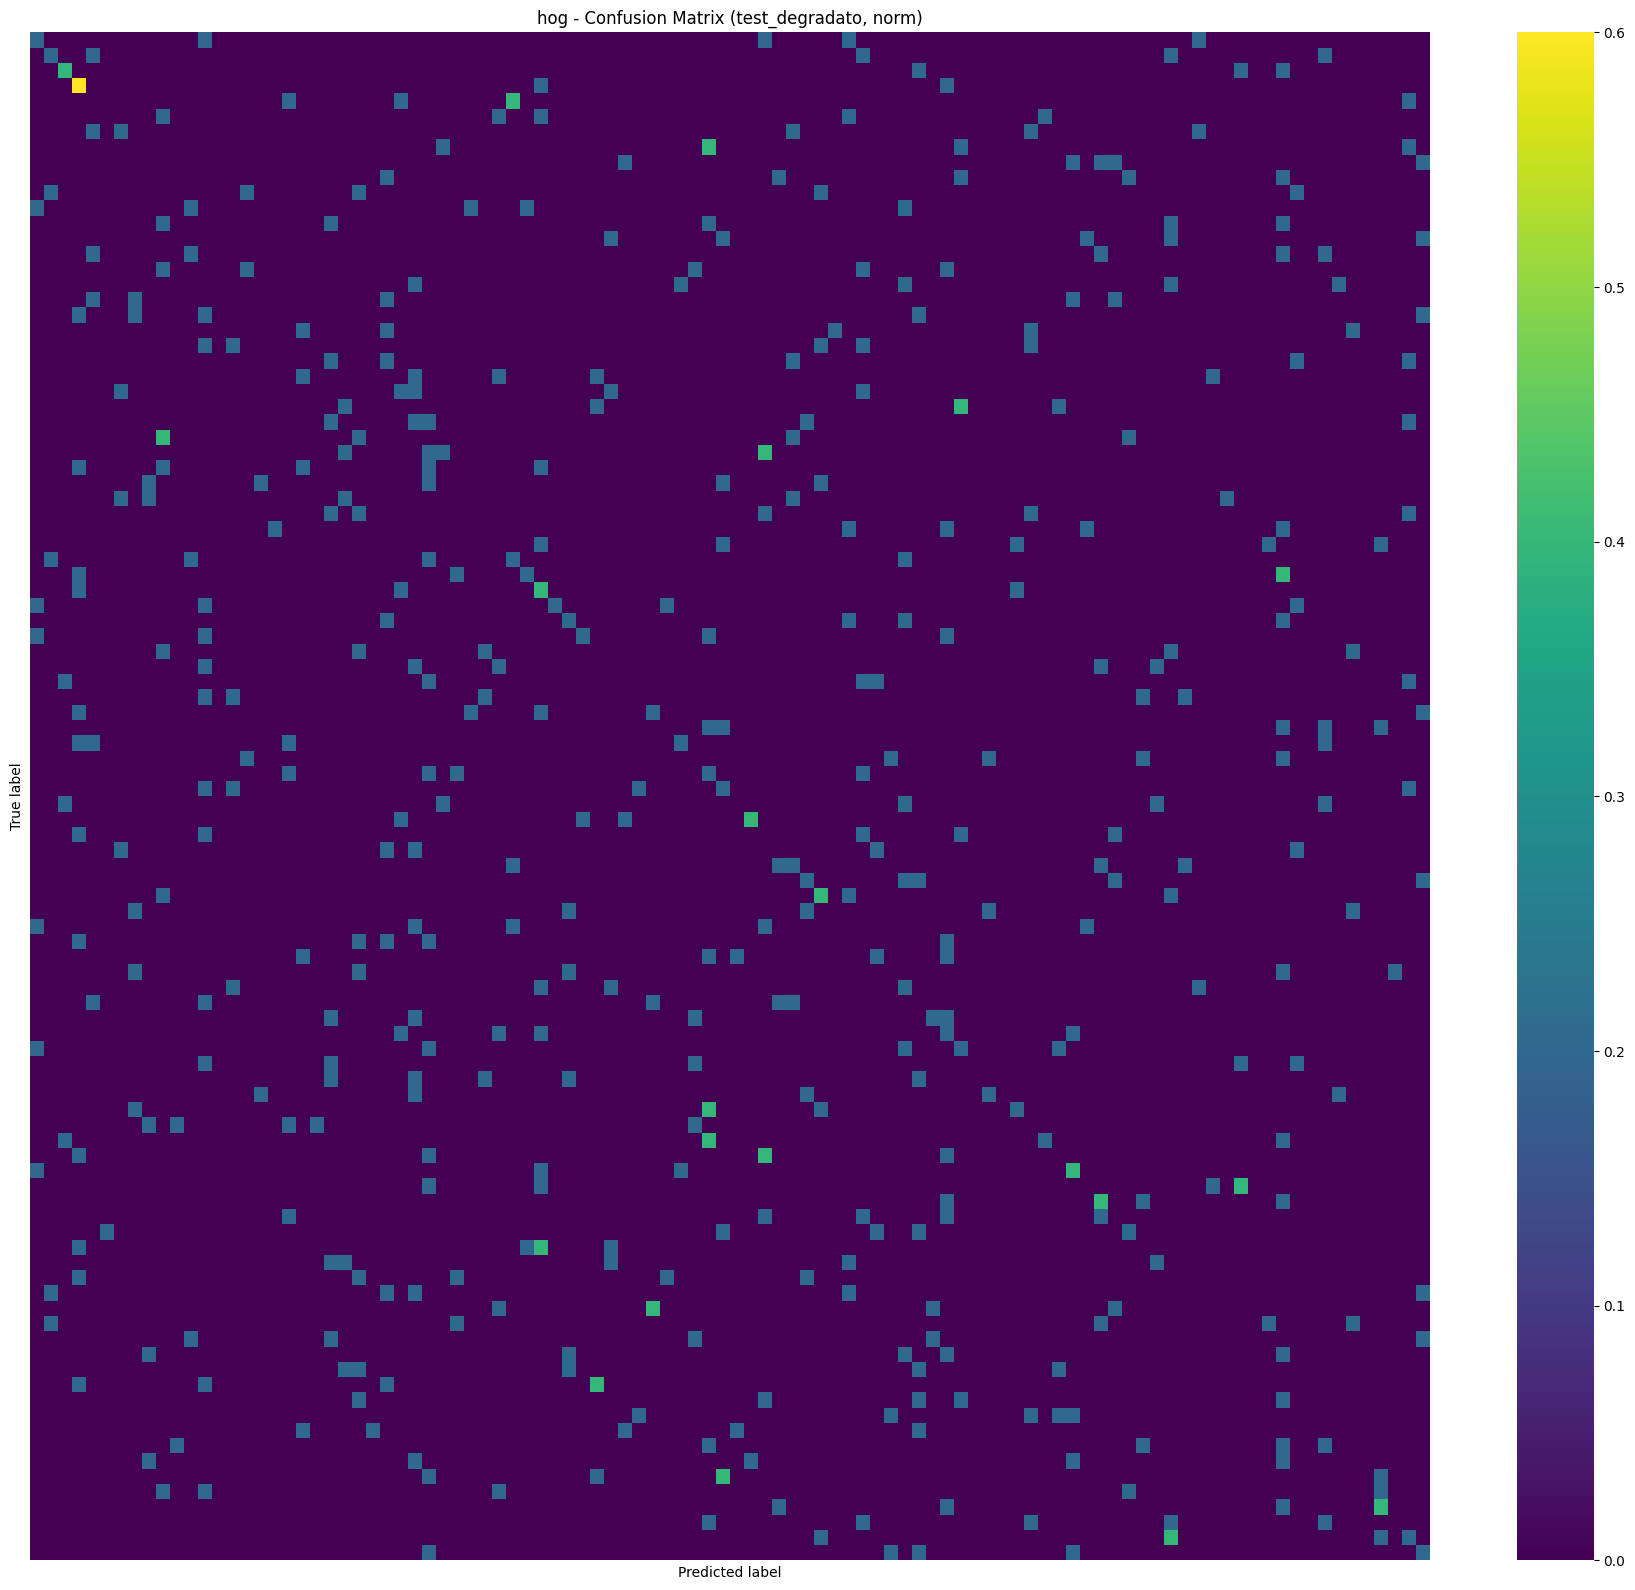


MODE = lbp
Best C (val split): 3.0 | Val Macro-F1: 0.0362
TEST(degradato) Accuracy: 0.0480
TEST(degradato) Macro-F1: 0.0330


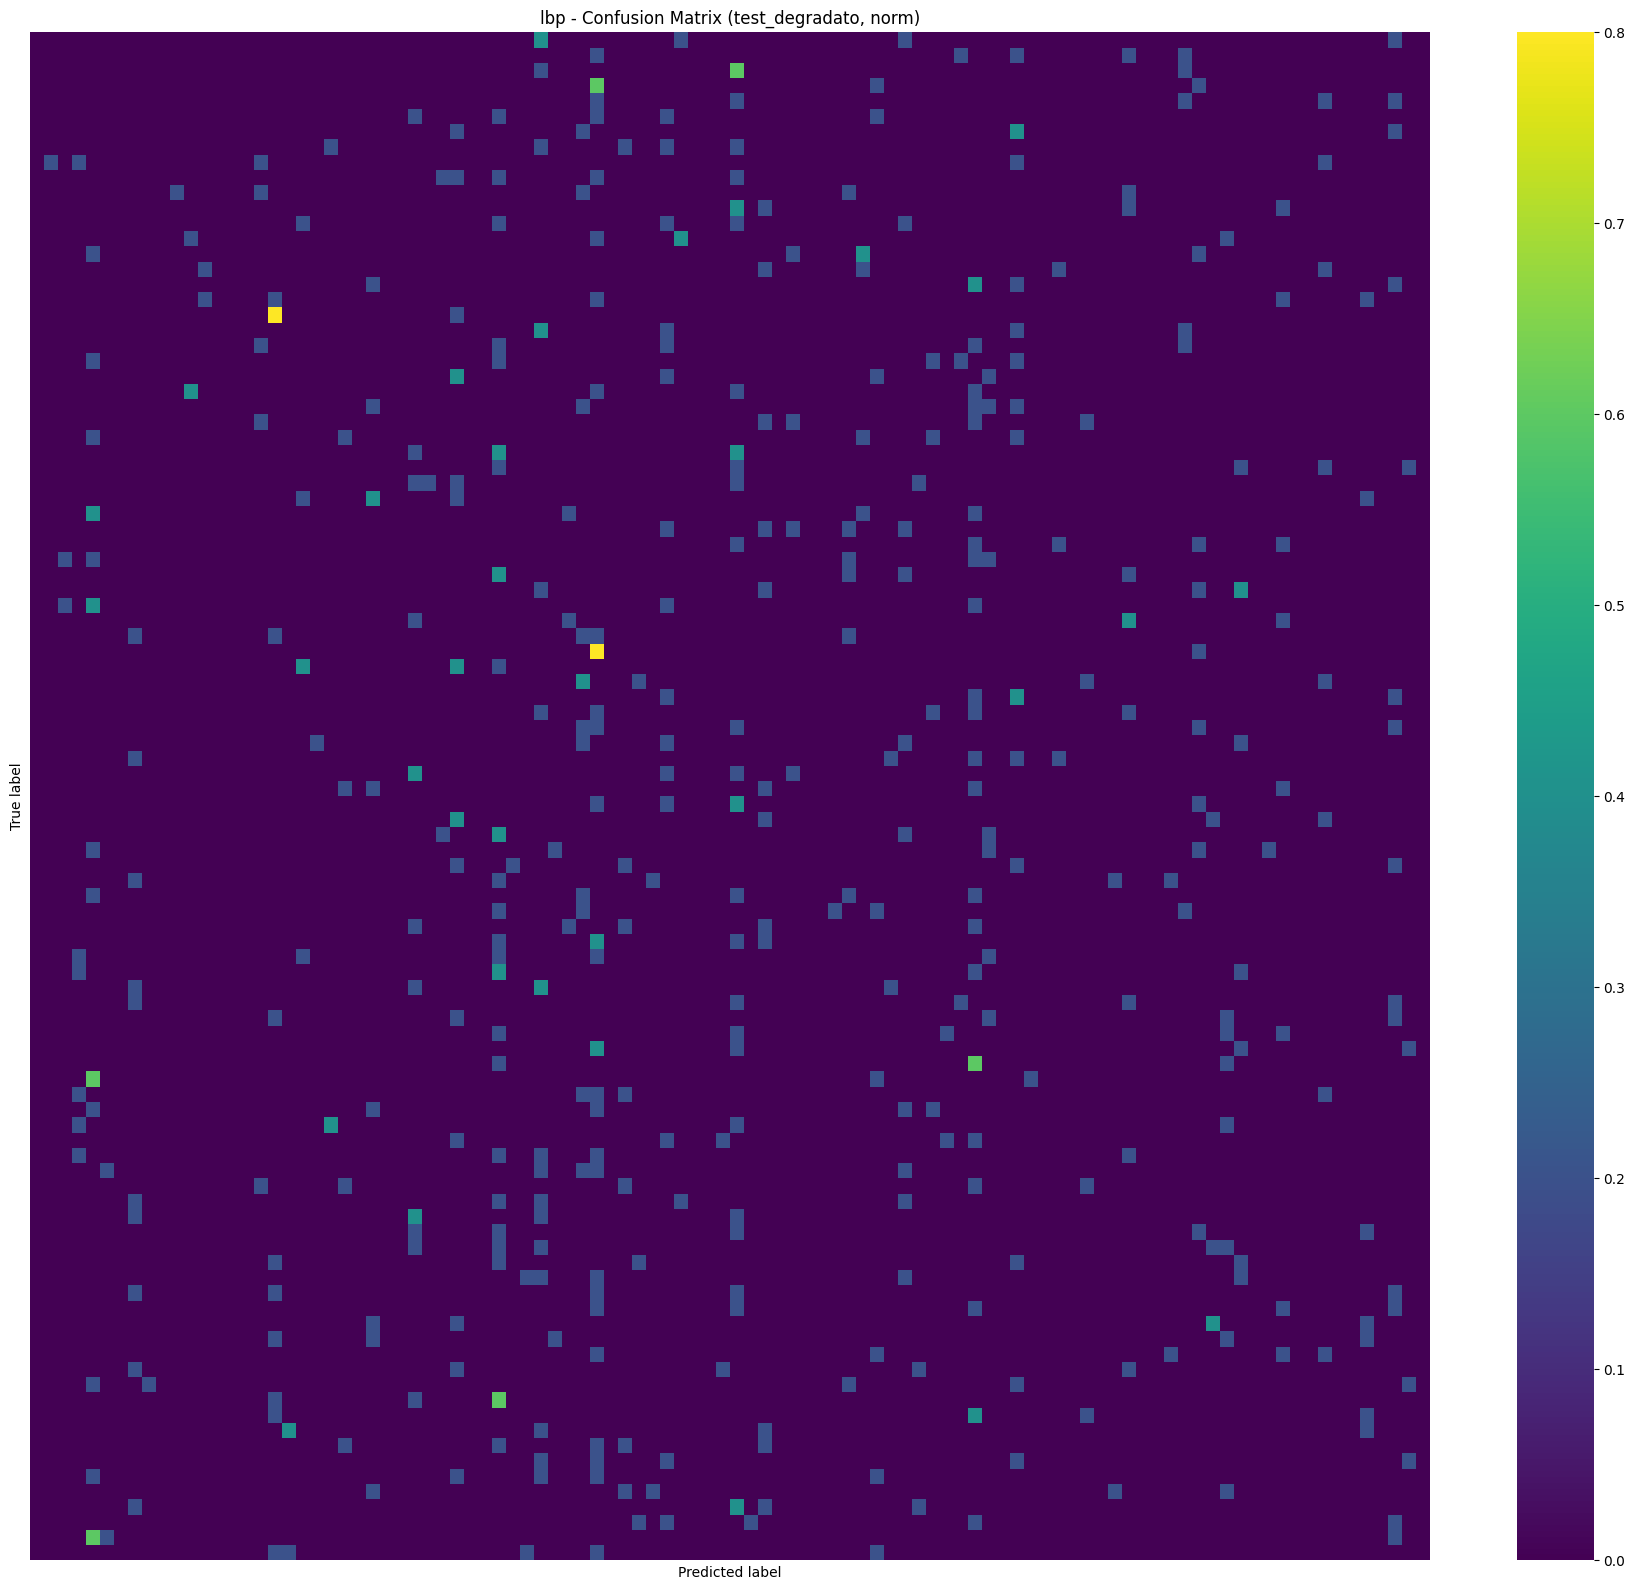


MODE = hog+lbp
Best C (val split): 0.1 | Val Macro-F1: 0.0923
TEST(degradato) Accuracy: 0.1000
TEST(degradato) Macro-F1: 0.0943


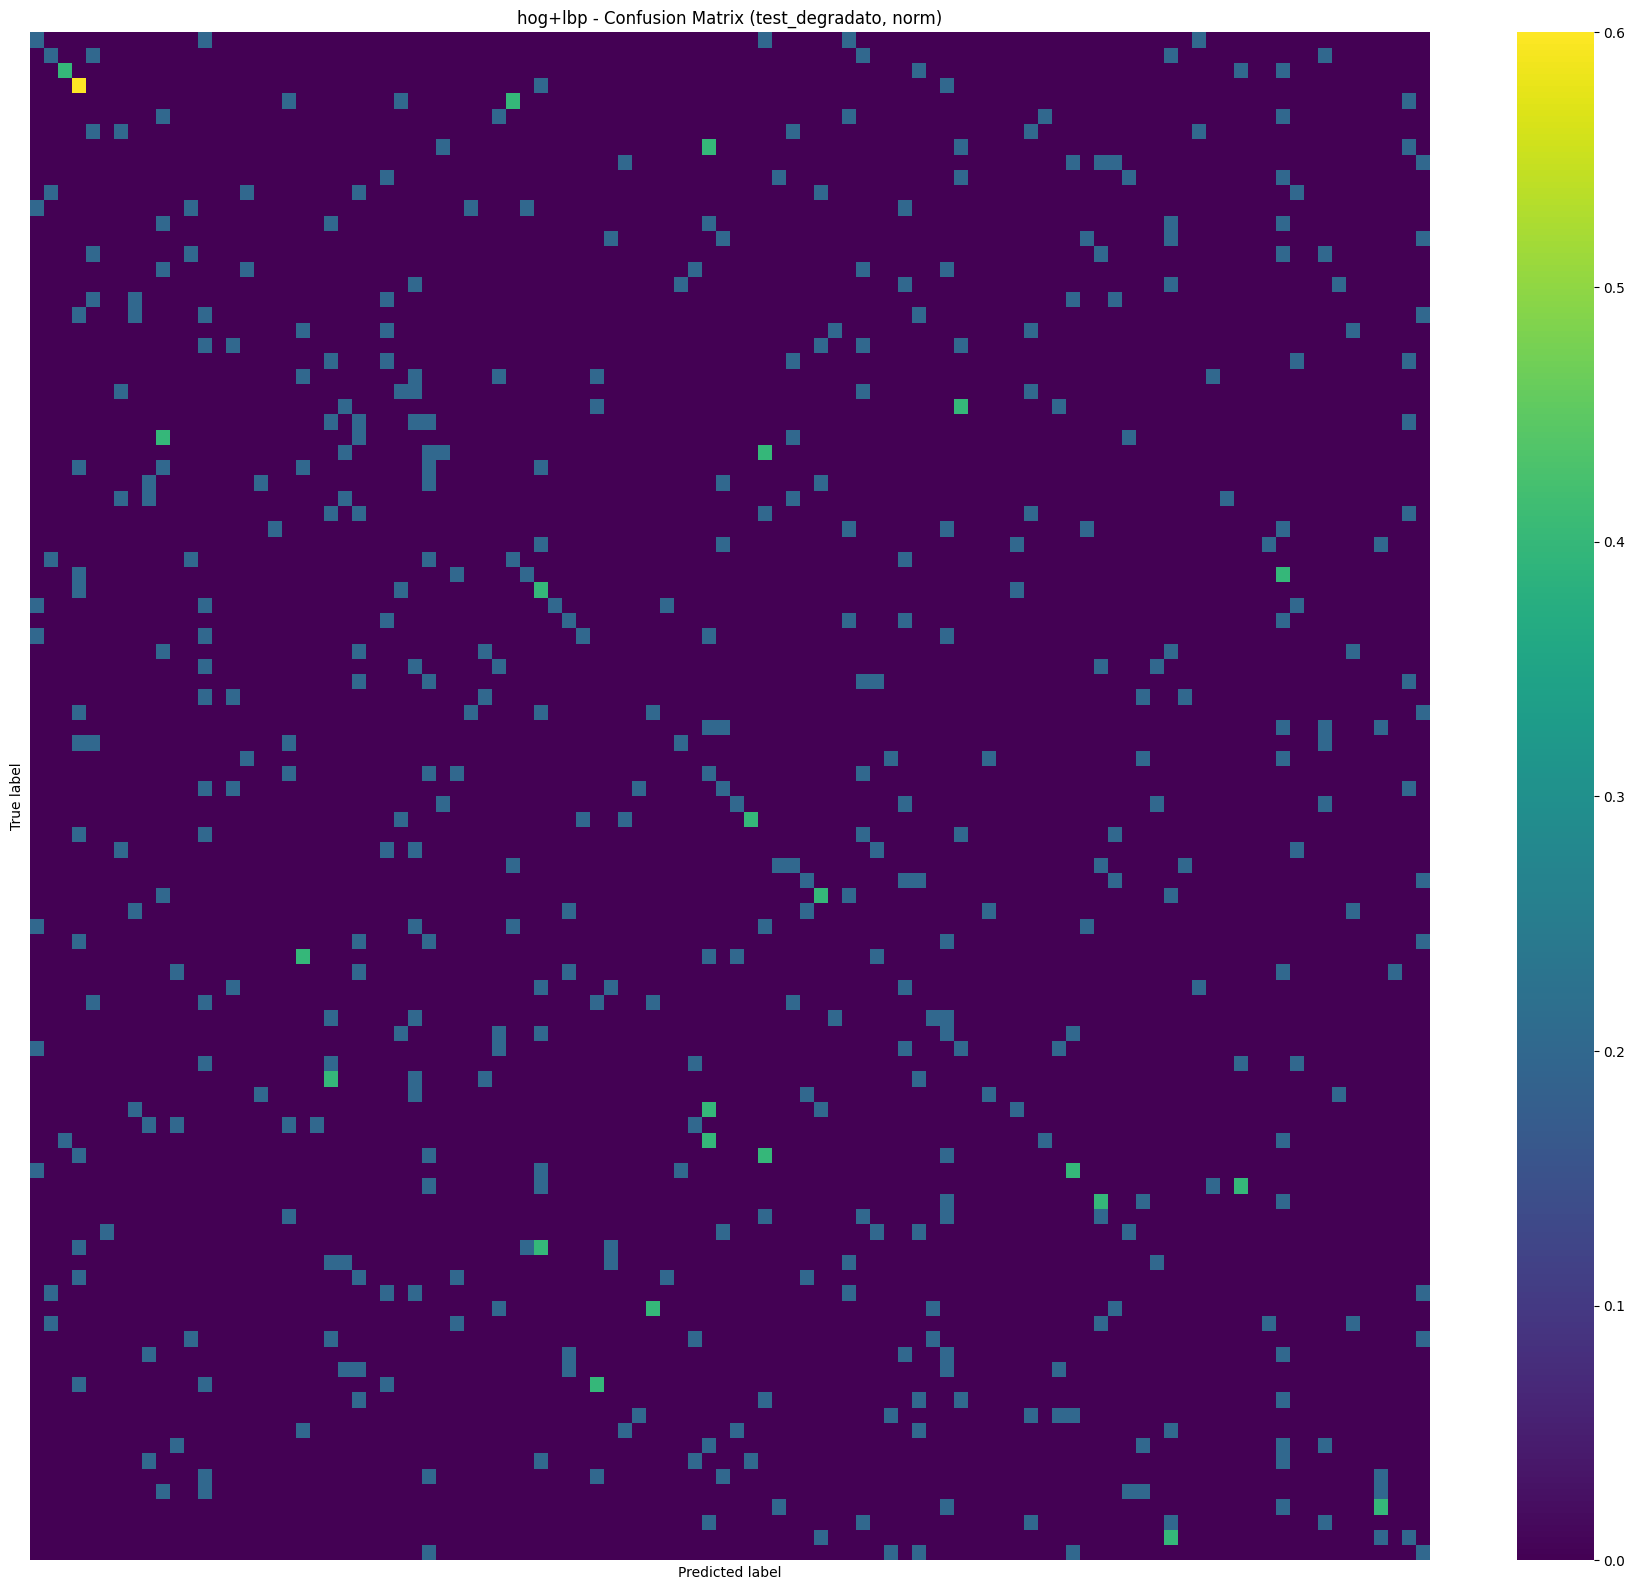

In [ ]:
modes = ["hog", "lbp", "hog+lbp"]
results = {}
cms = {}

for mode in modes:
    print(f"\n====================")
    print(f"MODE = {mode}")
    print(f"====================")

    X_fit, y_fit   = build_xy(fit_ds, cfg, mode)
    X_test, y_test = build_xy(test_ds, cfg, mode)

    best_C, best_val_f1, test_acc, test_f1, cm = tune_and_test(X_fit, y_fit, X_test, y_test, cfg)

    results[mode] = (best_C, best_val_f1, test_acc, test_f1)
    cms[mode] = cm   # viene salvata la CM

    print(f"Best C (val split): {best_C} | Val Macro-F1: {best_val_f1:.4f}")
    print(f"TEST(degradato) Accuracy: {test_acc:.4f}")
    print(f"TEST(degradato) Macro-F1: {test_f1:.4f}")

    plot_confusion_matrix(cm, title=f"{mode} - Confusion Matrix (test_degradato, norm)")

In [11]:
print("\n=== RIASSUNTO ===")
for mode, (best_C, best_val_f1, test_acc, test_f1) in results.items():
    print(f"{mode:7} | bestC={best_C:<4} | ValF1={best_val_f1:.4f} | TestAcc={test_acc:.4f} | TestF1={test_f1:.4f}")



=== RIASSUNTO ===
hog     | bestC=0.1  | ValF1=0.0923 | TestAcc=0.0980 | TestF1=0.0905
lbp     | bestC=3.0  | ValF1=0.0362 | TestAcc=0.0480 | TestF1=0.0330
hog+lbp | bestC=0.1  | ValF1=0.0923 | TestAcc=0.1000 | TestF1=0.0943


In [12]:
for mode, cm in cms.items():
    print(f"\n=== Top confusions: {mode} ===")
    print_top_confusions(cm, class_names, top_k=30)


=== Top confusions: hog ===

Top 30 coppie più confuse:

axe throwing → gaga  | 2 errori
baseball → ice yachting  | 2 errori
disc golf → rings  | 2 errori
field hockey → baton twirling  | 2 errori
figure skating men → judo  | 2 errori
giant slalom → trapeze  | 2 errori
rowing → ice yachting  | 2 errori
sailboat racing → ice yachting  | 2 errori
shot put → judo  | 2 errori
sidecar racing → table tennis  | 2 errori
snow boarding → golf  | 2 errori
sumo wrestling → horseshoe pitching  | 2 errori
track bicycle → high jump  | 2 errori
water cycling → jai alai  | 2 errori
wheelchair racing → speed skating  | 2 errori
air hockey → bmx  | 1 errori
air hockey → judo  | 1 errori
air hockey → nascar racing  | 1 errori
air hockey → sumo wrestling  | 1 errori
ampute football → axe throwing  | 1 errori
ampute football → olympic wrestling  | 1 errori
ampute football → speed skating  | 1 errori
ampute football → uneven bars  | 1 errori
archery → pole vault  | 1 errori
archery → table tennis  | 1 erro